In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import json
from os.path import expanduser
import sqlite3

#### compare PASEF features that were identified and see whether 3DID also detected them

In [45]:
experiment_name = 'P3856'
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'

EXPERIMENT_DIR = '/media/big-ssd/experiments/{}'.format(experiment_name)

RESULTS_DIR = '/media/big-ssd/results-P3856'
IDENTS_PASEF_DIR = '{}/P3856-results-cs-true-fmdw-true-2021-05-20-02-44-34/identifications-pasef'.format(RESULTS_DIR)
IDENTS_PASEF_FILE = '{}/exp-{}-identifications-pasef-recalibrated.pkl'.format(IDENTS_PASEF_DIR, experiment_name)

FEATURES_3DID_DIR = '{}/features-3did'.format(EXPERIMENT_DIR)
FEATURES_3DID_FILE = '{}/exp-{}-run-{}-features-3did-dedup.pkl'.format(FEATURES_3DID_DIR, experiment_name, run_name)

In [46]:
MAXIMUM_Q_VALUE = 0.01

In [47]:
# load the features identified by PASEF
with open(IDENTS_PASEF_FILE, 'rb') as handle:
    d = pickle.load(handle)
idents_pasef_df = d['identifications_df']
idents_pasef_df = idents_pasef_df[(idents_pasef_df.run_name == run_name) & (idents_pasef_df['percolator q-value'] <= MAXIMUM_Q_VALUE)]
# idents_pasef_df = idents_pasef_df[(idents_pasef_df.mono_mz > mz_lower) & (idents_pasef_df.mono_mz < mz_upper) & (idents_pasef_df.scan_apex > scan_lower) & (idents_pasef_df.rt_apex > rt_lower) & (idents_pasef_df.rt_apex < rt_upper)]

In [48]:
# load the features detected by 3DID
with open(FEATURES_3DID_FILE, 'rb') as handle:
    d = pickle.load(handle)
features_3did_df = d['features_df']

In [49]:
print('{} identified features from PASEF, {} features from 3DID'.format(len(idents_pasef_df), len(features_3did_df)))

8742 identified features from PASEF, 212043 features from 3DID


In [50]:
idents_pasef_df.charge.value_counts()

2    6918
3    1398
4     315
5      61
1      45
6       5
Name: charge, dtype: int64

In [51]:
features_3did_df.charge.value_counts()

2    172741
1     19993
3     15719
4      2395
5       910
6       198
7        50
8        37
Name: charge, dtype: int64

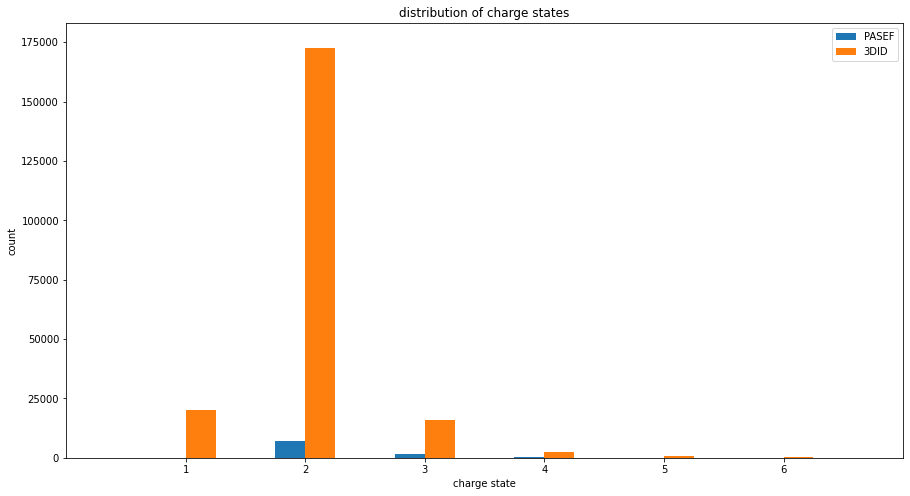

In [52]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

barwidth = 0.25

pos1 = [x - barwidth/2 for x in range(max(idents_pasef_df.charge.max(), features_3did_df.charge.max())+1)]
pos2 = [x + barwidth for x in pos1]

counts = np.bincount(idents_pasef_df.charge, minlength=9)
ax1.bar(pos1, counts, width=barwidth, align='center', label='PASEF')

counts = np.bincount(features_3did_df.charge, minlength=9)
ax1.bar(pos2, counts, width=barwidth, align='center', label='3DID')

ax1.set(xticks=range(1,idents_pasef_df.charge.max()+1), xlim=[0, idents_pasef_df.charge.max()+1])

plt.xlabel('charge state')
plt.ylabel('count')
plt.title('distribution of charge states')

plt.legend()
plt.show()

#### find the features in common

In [53]:
DUP_MZ_TOLERANCE_PPM = 5
DUP_SCAN_TOLERANCE = 20
DUP_RT_TOLERANCE = 10

In [54]:
# set up dup definitions for 3DID
MZ_TOLERANCE_PERCENT = DUP_MZ_TOLERANCE_PPM * 10**-4
features_3did_df['dup_mz'] = features_3did_df['monoisotopic_mz']  # shorthand to reduce verbosity
features_3did_df['dup_mz_ppm_tolerance'] = features_3did_df.dup_mz * MZ_TOLERANCE_PERCENT / 100
features_3did_df['dup_mz_lower'] = features_3did_df.dup_mz - features_3did_df.dup_mz_ppm_tolerance
features_3did_df['dup_mz_upper'] = features_3did_df.dup_mz + features_3did_df.dup_mz_ppm_tolerance
features_3did_df['dup_scan_lower'] = features_3did_df.scan_apex - DUP_SCAN_TOLERANCE
features_3did_df['dup_scan_upper'] = features_3did_df.scan_apex + DUP_SCAN_TOLERANCE
features_3did_df['dup_rt_lower'] = features_3did_df.rt_apex - DUP_RT_TOLERANCE
features_3did_df['dup_rt_upper'] = features_3did_df.rt_apex + DUP_RT_TOLERANCE

In [55]:
# set up dup definitions for PASEF
MZ_TOLERANCE_PERCENT = DUP_MZ_TOLERANCE_PPM * 10**-4
idents_pasef_df['dup_mz'] = idents_pasef_df['monoisotopic_mz']  # shorthand to reduce verbosity
idents_pasef_df['dup_mz_ppm_tolerance'] = idents_pasef_df.dup_mz * MZ_TOLERANCE_PERCENT / 100
idents_pasef_df['dup_mz_lower'] = idents_pasef_df.dup_mz - idents_pasef_df.dup_mz_ppm_tolerance
idents_pasef_df['dup_mz_upper'] = idents_pasef_df.dup_mz + idents_pasef_df.dup_mz_ppm_tolerance
idents_pasef_df['dup_scan_lower'] = idents_pasef_df.scan_apex - DUP_SCAN_TOLERANCE
idents_pasef_df['dup_scan_upper'] = idents_pasef_df.scan_apex + DUP_SCAN_TOLERANCE
idents_pasef_df['dup_rt_lower'] = idents_pasef_df.rt_apex - DUP_RT_TOLERANCE
idents_pasef_df['dup_rt_upper'] = idents_pasef_df.rt_apex + DUP_RT_TOLERANCE

In [56]:
idents_pasef_df.sort_values(by=['deconvolution_score'], ascending=False, inplace=True)
features_3did_df.sort_values(by=['deconvolution_score'], ascending=False, inplace=True)

In [57]:
# find whether a feature detected by PASEF was also detected by 3DID
common_l = []
features_processed = set()
for row in idents_pasef_df.itertuples():
    if row.feature_id not in features_processed:
        df = features_3did_df[(row.charge == features_3did_df.charge) & (row.dup_mz >= features_3did_df.dup_mz_lower) & (row.dup_mz <= features_3did_df.dup_mz_upper) & (row.scan_apex >= features_3did_df.dup_scan_lower) & (row.scan_apex <= features_3did_df.dup_scan_upper) & (row.rt_apex >= features_3did_df.dup_rt_lower) & (row.rt_apex <= features_3did_df.dup_rt_upper)].copy()
        if len(df) > 0:
            common_l.append(
                {
                    'feature_id_pasef':row.feature_id, 
                    'deconv_score_pasef':row.deconvolution_score,
                    'feature_intensity_pasef':row.feature_intensity,
                    'feature_id_3did':df.iloc[0].feature_id, 
                    'deconv_score_3did':df.iloc[0].deconvolution_score,
                    'feature_intensity_3did':df.iloc[0].feature_intensity
                }
            )
            # record the features that have been processed
            features_processed.update(set(df.feature_id.tolist()))

common_df = pd.DataFrame(common_l)

In [58]:
print('{} features in common'.format(len(common_df)))

6608 features in common


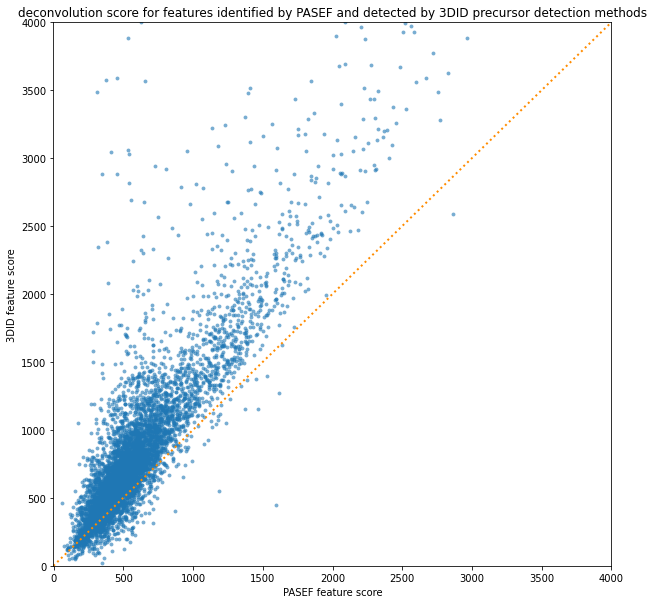

In [59]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)

plt.margins(0.06)
plt.title('deconvolution score for features identified by PASEF and detected by 3DID precursor detection methods')

ax.scatter(common_df.deconv_score_pasef, common_df.deconv_score_3did, marker='o', lw=0, s=15, alpha=0.6)

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle=':', linewidth=2, color='darkorange')

plt.xlim((-1,4000))
plt.ylim((-1,4000))

plt.xlabel('PASEF feature score')
plt.ylabel('3DID feature score')

plt.show()

#### visualise a feature detected by PASEF but not by 3DID

In [60]:
# find the PASEF feature IDs that are not in the common set
feature_ids_not_found_by_3did_l = list(set(idents_pasef_df.feature_id.to_list()) - set(common_df.feature_id_pasef.to_list()))


In [61]:
len(feature_ids_not_found_by_3did_l)

2134

In [62]:
import random

pasef_feature_not_detected = random.choice(feature_ids_not_found_by_3did_l)
pasef_feature_not_detected

3319201

#### plot the intensities of features identified by PASEF but not detected by 3DID

In [63]:
idents_pasef_df['log_feature_intensity'] = np.log10(idents_pasef_df.feature_intensity)

In [64]:
idents_pasef_df['not_detected_3did'] = idents_pasef_df.apply(lambda row: row.feature_id in feature_ids_not_found_by_3did_l, axis=1)

In [65]:
idents_not_detected_3did_df = idents_pasef_df[(idents_pasef_df.not_detected_3did == True)]

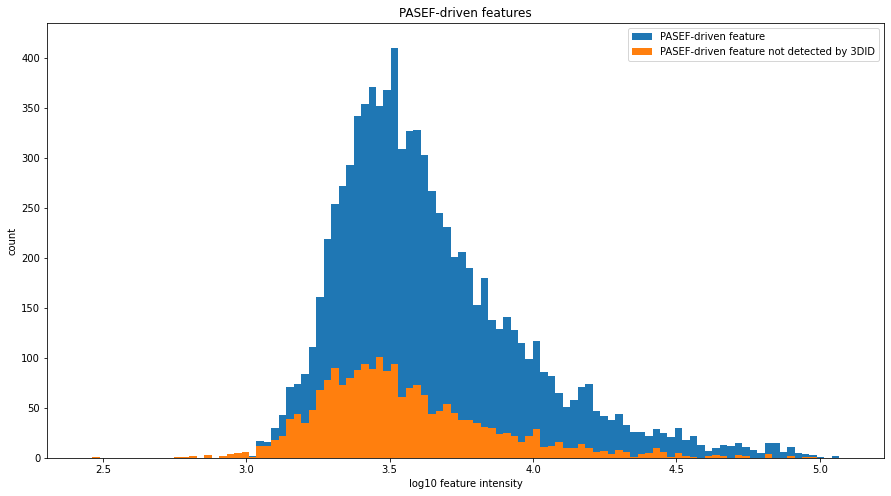

In [66]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('PASEF-driven features')

bins = 100
hist, bins, _ = plt.hist(idents_pasef_df.log_feature_intensity, bins=bins, label='PASEF-driven feature')
hist, bins, _ = plt.hist(idents_not_detected_3did_df.log_feature_intensity, bins=bins, label='PASEF-driven feature not detected by 3DID')

plt.xlabel('log10 feature intensity')
plt.ylabel('count')

# plt.xlim((-20,20))
# plt.ylim((0,300))

plt.legend()
plt.show()

#### inspect a feature identified by PASEF but not detected by 3DID